In [1]:
import pandas as pd
from cluster_comparison import perform_umap, perform_hdbscan, calculate_silhouette
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
# Sample data and demographics DataFrames, replace these with your actual DataFrames
raw_data = pd.read_csv('/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23_DNA.csv')
data_symp_groups = pd.read_csv('data/skew_corr_groupadd.csv', usecols=['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision'])
data_symp_groups_all = pd.read_csv('data/skew_corr_groupadd.csv')
demographics = pd.read_csv('/Users/leo/Programming/PLR/Leo/data/non_binary_data_processed.csv')

# combine demographics and data_symp_group_all 
demo_all = pd.concat([demographics, data_symp_groups_all], axis=1)

# combine demographics and data_symp_group
demo_groups = pd.concat([demographics, data_symp_groups], axis=1)

Generations:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d


Top 5 individuals in generation 1:
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7337600588798523
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7193141579627991
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7193141579627991
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7193141579627991
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.6941559314727783
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
Numb

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 2:
  Genome: (0.3048274311766477, 0.20609596000132982, 25, 17), Fitness: 0.7440875172615051
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=25, n_components=17
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7337600588798523
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7337600588798523
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 15), Fitness: 0.7337600588798523
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=15
  Genome: (0.3048274311766477, 0.20609596000132982, 43, 20), Fitness: 0.7294278740882874
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=43, n_components=20
Numb

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 3:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.3048274311766477, 0.20609596000132982, 46, 24), Fitness: 0.7596391439437866
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=46, n_components=24
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 24), Fitness: 0.7497654557228088
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=24
  Genome: (0.3048274311766477, 0.3548728004477896, 26, 22), Fitness: 0.7393591403961182
    n_neighbors=0.3048274311766477, min_dist=0.3548728004477896, min_cluster_size=26, n_components=22
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 23), Fitness: 0.7318940758705139
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=23
Number o

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 4:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 24), Fitness: 0.7492117881774902
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=24
  Genome: (0.3048274311766477, 0.2833326775007818, 28, 24), Fitness: 0.7473185062408447
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=28, n_components=24
  Genome: (0.9222951409279802, 0.3623668202754008, 29, 24), Fitness: 0.7400004267692566
    n_neighbors=0.9222951409279802, min_dist=0.3623668202754008, min_cluster_size=29, n_components=24
Number of mu

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 5:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.5523788299386697, 0.3623668202754008, 26, 22), Fitness: 0.7468569278717041
    n_neighbors=0.5523788299386697, min_dist=0.3623668202754008, min_cluster_size=26, n_components=22
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 23), Fitness: 0.7456952929496765
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=23
  Genome: (0.3048274311766477, 0.2721546156943233, 46, 24), Fitness: 0.737743079662323
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=46, n_components=24
  Genome: (0.3048274311766477, 0.3623668202754008, 30, 23), Fitness: 0.7342801690101624
    n_neighbors=0.3048274311766477, min_dist=0.3623668202754008, min_cluster_size=30, n_components=23
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value f


Top 5 individuals in generation 6:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 23), Fitness: 0.7498823404312134
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=23
  Genome: (0.3048274311766477, 0.2833326775007818, 30, 44), Fitness: 0.7485994696617126
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=30, n_components=44
  Genome: (0.3048274311766477, 0.3623668202754008, 30, 23), Fitness: 0.7475734949111938
    n_neighbors=0.3048274311766477, min_dist=0.3623668202754008, min_cluster_size=30, n_components=23
  Genome: (0.6376980394102897, 0.3623668202754008, 29, 11), Fitness: 0.7308123707771301
    n_neighbors=0.6376980394102897, min_dist=0.3623668202754008, min_cluster_size=29, n_components=11
Number of mu

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d


Top 5 individuals in generation 7:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.3048274311766477, 0.3623668202754008, 28, 39), Fitness: 0.7605175375938416
    n_neighbors=0.3048274311766477, min_dist=0.3623668202754008, min_cluster_size=28, n_components=39
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 43), Fitness: 0.7561036944389343
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=43
  Genome: (2, 0.2721546156943233, 30, 23), Fitness: 0.7352491021156311
    n_neighbors=2, min_dist=0.2721546156943233, min_cluster_size=30, n_components=23
  Genome: (0.9222951409279802, 0.3623668202754008, 29, 36), Fitness: 0.7316201329231262
    n_neighbors=0.9222951409279802, min_dist=0.3623668202754008, min_cluster_size=29, n_components=36
Number of mutations: 13


/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 8:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.3048274311766477, 0.20609596000132982, 29, 23), Fitness: 0.7520119547843933
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=29, n_components=23
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 23), Fitness: 0.7428136467933655
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=23
  Genome: (0.3048274311766477, 0.2833326775007818, 6, 23), Fitness: 0.7385400533676147
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=6, n_components=23
  Genome: (0.3048274311766477, 0.20609596000132982, 30, 11), Fitness: 0.7307930588722229
    n_neighbors=0.3048274311766477, min_dist=0.20609596000132982, min_cluster_size=30, n_components=11
Number of 

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value f


Top 5 individuals in generation 9:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.9222951409279802, 0.3623668202754008, 29, 29), Fitness: 0.7356183528900146
    n_neighbors=0.9222951409279802, min_dist=0.3623668202754008, min_cluster_size=29, n_components=29
  Genome: (0.9222951409279802, 0.3623668202754008, 28, 28), Fitness: 0.7304617762565613
    n_neighbors=0.9222951409279802, min_dist=0.3623668202754008, min_cluster_size=28, n_components=28
  Genome: (0.9222951409279802, 0.3623668202754008, 29, 23), Fitness: 0.7268099188804626
    n_neighbors=0.9222951409279802, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
  Genome: (0.39951291863614946, 0.3623668202754008, 25, 17), Fitness: 0.7245910167694092
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=25, n_components=17
Number of mu

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d


Top 5 individuals in generation 10:
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.9222951409279802, 0.2833326775007818, 29, 45), Fitness: 0.7504995465278625
    n_neighbors=0.9222951409279802, min_dist=0.2833326775007818, min_cluster_size=29, n_components=45
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 12), Fitness: 0.7360599637031555
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=12
  Genome: (0.9391600249531215, 0.3623668202754008, 29, 23), Fitness: 0.7275657653808594
    n_neighbors=0.9391600249531215, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 11), Fitness: 0.7224639058113098
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=11
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.


Top 5 individuals in generation 11:
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7675155997276306
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.3048274311766477, 0.2833326775007818, 25, 50), Fitness: 0.7613025307655334
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=25, n_components=50
  Genome: (0.10800043969860407, 0.3623668202754008, 29, 23), Fitness: 0.7467805743217468
    n_neighbors=0.10800043969860407, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7458348870277405
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 12), Fitness: 0.7347918748855591
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=12
Number of m

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.


Top 5 individuals in generation 12:
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7709786295890808
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 23), Fitness: 0.7351081371307373
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7344098687171936
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 35), Fitness: 0.7324703335762024
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=35
  Genome: (0.9222951409279802, 0.3623668202754008, 29, 23), Fitness: 0.729263186454773
    n_neighbors=0.9222951409279802, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
Number of 

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d


Top 5 individuals in generation 13:
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7639716267585754
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7538647651672363
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 42), Fitness: 0.7455706596374512
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=42
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7448037266731262
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.744123101234436
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
Number of mu

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 14:
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7662400603294373
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7628548741340637
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.3048274311766477, 0.3623668202754008, 29, 39), Fitness: 0.7607925534248352
    n_neighbors=0.3048274311766477, min_dist=0.3623668202754008, min_cluster_size=29, n_components=39
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 23), Fitness: 0.7387260794639587
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=23
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 23), Fitness: 0.7375801205635071
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 15:
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 40), Fitness: 0.771593451499939
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=40
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 42), Fitness: 0.7609919309616089
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 42), Fitness: 0.7584881782531738
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=42
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.7494654655456543
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 42), Fitness: 0.748363196849823
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=42
Number of m

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 16:
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 40), Fitness: 0.7595361471176147
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=40
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 23), Fitness: 0.7520718574523926
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 23), Fitness: 0.745765745639801
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7452225685119629
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
Number of 

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  return result
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  return result
/Users/leo/Programming/PLR/Leo/env/lib/


Top 5 individuals in generation 17:
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7363446354866028
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 23), Fitness: 0.7358797788619995
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7341513633728027
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2833326775007818, 29, 23), Fitness: 0.7329526543617249
    n_neighbors=0.9222951409279802, min_dist=0.2833326775007818, min_cluster_size=29, n_components=23
Number of

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 18:
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.7505291700363159
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 23), Fitness: 0.748629629611969
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 23), Fitness: 0.7467588782310486
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 23), Fitness: 0.7438215017318726
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
Number of mu

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-


Top 5 individuals in generation 19:
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 23), Fitness: 0.744107186794281
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 23), Fitness: 0.7383100390434265
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 23), Fitness: 0.7382050156593323
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=23
  Genome: (0.39951291863614946, 0.3623668202754008, 29, 23), Fitness: 0.737952709197998
    n_neighbors=0.39951291863614946, min_dist=0.3623668202754008, min_cluster_size=29, n_components=23
Number of

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spec


Top 5 individuals in generation 20:
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
Number of

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 21:
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 48), Fitness: 0.7831499576568604
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 35), Fitness: 0.7607600092887878
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
Number of m

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 22:
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 48), Fitness: 0.7831499576568604
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.39951291863614946, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.39951291863614946, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 48), Fitness: 0.7765994668006897
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
Number of m

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 23:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 35), Fitness: 0.7776287794113159
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
  Genome: (0.3048274311766477, 0.2833326775007818, 26, 48), Fitness: 0.7771695256233215
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=26, n_components=48
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 48), Fitness: 0.7765994668006897
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 24:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2833326775007818, 29, 48), Fitness: 0.7765994668006897
    n_neighbors=0.9222951409279802, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7746824622154236
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2833326775007818, 26, 35), Fitness: 0.765837550163269
    n_neighbors=0.9222951409279802, min_dist=0.2833326775007818, min_cluster_size=26, n_components=35
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 35), Fitness: 0.7644218802452087
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
Number of muta

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 25:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 35), Fitness: 0.7748127579689026
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 35), Fitness: 0.7729991674423218
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 26:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 43), Fitness: 0.7746564745903015
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=43
  Genome: (0.6757706356698308, 0.2833326775007818, 29, 35), Fitness: 0.7694124579429626
    n_neighbors=0.6757706356698308, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
  Genome: (0.6757706356698308, 0.2833326775007818, 29, 35), Fitness: 0.766453742980957
    n_neighbors=0.6757706356698308, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
Number of muta

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 27:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 35), Fitness: 0.7800698280334473
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 35), Fitness: 0.7746606469154358
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
  Genome: (0.6757706356698308, 0.2833326775007818, 29, 35), Fitness: 0.7712785005569458
    n_neighbors=0.6757706356698308, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
  Genome: (0.3048274311766477, 0.2833326775007818, 29, 35), Fitness: 0.7684270739555359
    n_neighbors=0.3048274311766477, min_dist=0.2833326775007818, min_cluster_size=29, n_components=35
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 28:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2833326775007818, 29, 48), Fitness: 0.7765994668006897
    n_neighbors=0.6757706356698308, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 35), Fitness: 0.775461733341217
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 47), Fitness: 0.7704026699066162
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=47
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 35), Fitness: 0.7673023343086243
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
Number of muta

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 29:
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2833326775007818, 29, 48), Fitness: 0.7765994668006897
    n_neighbors=0.6757706356698308, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2833326775007818, 29, 48), Fitness: 0.7765994668006897
    n_neighbors=0.9222951409279802, min_dist=0.2833326775007818, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 35), Fitness: 0.7746648788452148
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
Number of mut

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 30:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
Number of m

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 31:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.9222951409279802, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.2721546156943233, 29, 48), Fitness: 0.7783370018005371
    n_neighbors=0.3048274311766477, min_dist=0.2721546156943233, min_cluster_size=29, n_components=48
Number of m

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 32:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.2721546156943233, 29, 35), Fitness: 0.778682291507721
    n_neighbors=0.6757706356698308, min_dist=0.2721546156943233, min_cluster_size=29, n_components=35
Number

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 33:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.3048274311766477, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 35), Fitness: 0.7818458676338196
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=35
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 34:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.3048274311766477, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.3048274311766477, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 40, 35), Fitness: 0.8004958629608154
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=40, n_components=35
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 35:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 40, 48), Fitness: 0.8057063817977905
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=40, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 35), Fitness: 0.7986598014831543
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=35
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 36:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 37:
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 38:
  Genome: (0.6757706356698308, 0.07249071639146876, 21, 48), Fitness: 0.8228880763053894
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=21, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 39:
  Genome: (0.6757706356698308, 0.07249071639146876, 21, 48), Fitness: 0.8228880763053894
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=21, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 40:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 21, 48), Fitness: 0.8228880763053894
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=21, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 41:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 42:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 43:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 38, 35), Fitness: 0.8200111389160156
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=38, n_components=35
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 44:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 45:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 46:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 47:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 48:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 49:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 


Top 5 individuals in generation 50:
  Genome: (0.6757706356698308, 0.04030749239323905, 29, 48), Fitness: 0.8556180596351624
    n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
  Genome: (0.6757706356698308, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.6757706356698308, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
  Genome: (0.9222951409279802, 0.07249071639146876, 29, 48), Fitness: 0.8198971748352051
    n_neighbors=0.9222951409279802, min_dist=0.07249071639146876, min_cluster_size=29, n_components=48
Num


/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to


Best parameters found:
  n_neighbors=0.6757706356698308, min_dist=0.04030749239323905, min_cluster_size=29, n_components=48
Best silhouette score: 0.8556180596351624


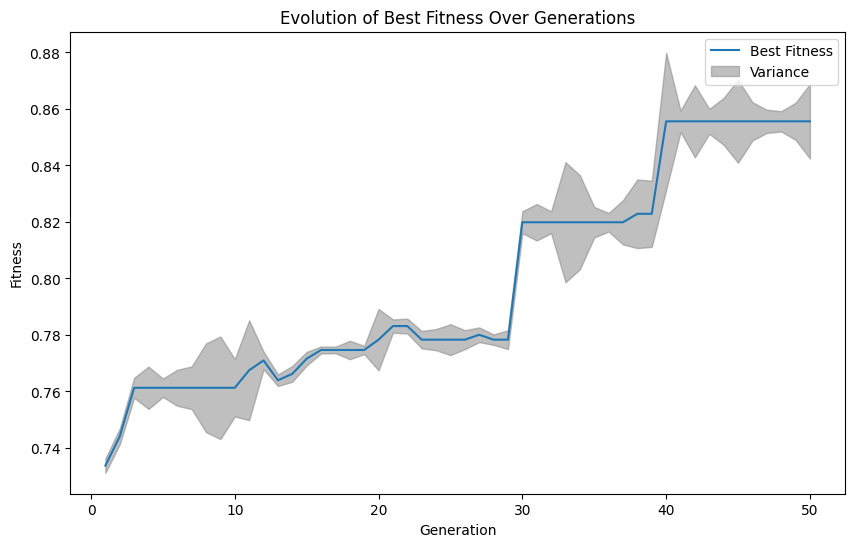

In [3]:
# Initialize variables for adaptive mutation
last_best_fitness = -1
increased_mutation_rate = 0.2

# Fitness function
def fitness(params):
    n_neighbors, min_dist, min_cluster_size, n_components = params
    
    # Validate n_neighbors
    n_neighbors = max(2, int(n_neighbors))  # Ensure n_neighbors is an integer and greater than 1
    
    min_cluster_size = max(2, int(min_cluster_size))
    n_components = max(2, int(n_components))
    min_dist = min(min_dist, 1.0)
    
    dataset_name, dataset = random.choice(list(datasets.items()))
    dataset = dataset.dropna()
    umap_result = perform_umap(dataset, n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    labels = perform_hdbscan(umap_result, min_cluster_size=min_cluster_size)
    score = calculate_silhouette(umap_result, labels)
    return score

# Datasets to consider
datasets = {'data_symp_groups_all': data_symp_groups_all}  # Replace with your actual dataset

# Genetic Algorithm Parameters
population_size = 100
n_generations = 50
selection_rate = 0.3
mutation_rate = 0.05

# Initialize population
population = []
for _ in range(population_size // 4):
    population.append((0.3048274311766477, 0.20609596000132982, 30, 15))
    population.append((random.randint(21, 35), random.uniform(0.26, 0.5), random.randint(21, 35), random.randint(11, 18)))
    population.append((random.randint(36, 45), random.uniform(0.51, 0.75), random.randint(36, 45), random.randint(19, 22)))
    population.append((random.randint(46, 50), random.uniform(0.76, 1.0), random.randint(46, 50), random.randint(23, 25)))

# To store best fitness and variance for each generation
best_fitnesses = []
variances = []

# Main GA loop
for generation in tqdm(range(n_generations), desc="Generations"):
    # Evaluate fitness of each individual in parallel using joblib
    scores = Parallel(n_jobs=-1)(delayed(fitness)(ind) for ind in population)
    
    # Store best fitness and variance
    best_fitness = max(scores)
    best_fitnesses.append(best_fitness)
    variances.append(np.var(scores))
    
    # Adaptive mutation rate
    if best_fitness <= last_best_fitness:
        mutation_rate = increased_mutation_rate
    else:
        mutation_rate = 0.1
    last_best_fitness = best_fitness
    
    # Elitism: Keep the best individual
    best_idx = scores.index(best_fitness)
    best_individual = population[best_idx]
    
    # Print the top 5 individuals
    top5_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]
    print(f"\nTop 5 individuals in generation {generation+1}:")
    for i in top5_idx:
        print(f"  Genome: {population[i]}, Fitness: {scores[i]}")
        print(f"    n_neighbors={population[i][0]}, min_dist={population[i][1]}, min_cluster_size={population[i][2]}, n_components={population[i][3]}")
    
    # Roulette wheel selection
    fitness_sum = sum(scores)
    selected_population = []
    for _ in range(int(selection_rate * population_size)):
        pick = random.uniform(0, fitness_sum)
        current = 0
        for i in range(len(scores)):
            current += scores[i]
            if current > pick:
                selected_population.append(population[i])
                break
    
    # Crossover (mate) the selected individuals
    children = []
    while len(children) < population_size - len(selected_population) - 1:
        parent1, parent2 = random.sample(selected_population, 2)
        crossover_point = random.randint(1, len(parent1) - 1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        children.append(child)
    
    # Mutation
    mutations = 0
    for i in range(len(children)):
        if random.random() < mutation_rate:
            mutations += 1
            mutate_pos = random.randint(0, len(children[i]) - 1)
            new_value = random.choice([
                random.randint(5, 50),
                random.uniform(0.0, 1.0),
                random.randint(5, 50),
                random.randint(2, 25)
            ])
            children[i] = children[i][:mutate_pos] + (new_value,) + children[i][mutate_pos+1:]
    
    print(f"Number of mutations: {mutations}")
    
    # Create new population
    population = selected_population + children

    # Add the best individual back into the population
    population.append(best_individual)

# Evaluate the final population and find the best individual
final_scores = Parallel(n_jobs=-1)(delayed(fitness)(ind) for ind in population)
best_idx = max(range(len(final_scores)), key=lambda i: final_scores[i])
best_individual = population[best_idx]

# Print best parameters and silhouette score
print("\nBest parameters found:")
print(f"  n_neighbors={best_individual[0]}, min_dist={best_individual[1]}, min_cluster_size={best_individual[2]}, n_components={best_individual[3]}")
print(f"Best silhouette score: {final_scores[best_idx]}")

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_generations + 1), best_fitnesses, label='Best Fitness')
plt.fill_between(range(1, n_generations + 1), 
                np.array(best_fitnesses) - np.array(variances), 
                np.array(best_fitnesses) + np.array(variances), 
                color='gray', alpha=0.5, label='Variance')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution of Best Fitness Over Generations')
plt.legend()
plt.show()
